In [1]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [2]:
ctx = mx.gpu()

In [4]:
batch_size = 64
num_inputs = 784
num_outputs = 10

def transform(data, label):
    return data.astype(np.float32) / 255, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True, transform=transform),
    batch_size, shuffle=True)
test_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False, transform=transform),
    batch_size, shuffle=False)

In [5]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_outputs))

In [6]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

In [10]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
trainer = gluon.Trainer(net.collect_params(), "sgd", {"learning_rate": 0.1})

In [12]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [13]:
evaluate_accuracy(test_data, net)

0.064799999999999996

In [14]:
epochs = 4
moving_loss = 0.
smoothing_constant = 0.01
niter = 0

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        niter += 1
        moving_loss = (1 - smoothing_constant) * moving_loss + \
            (smoothing_constant) * nd.mean(loss).asscalar()
        est_loss = moving_loss / (1 - (1 - smoothing_constant) ** niter)
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, est_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.02871056121, Train_acc 0.795183333333, Test_acc 0.7981
Epoch 1. Loss: 0.788657471307, Train_acc 0.837933333333, Test_acc 0.8405
Epoch 2. Loss: 0.703146208204, Train_acc 0.85465, Test_acc 0.8553
Epoch 3. Loss: 0.588087251581, Train_acc 0.865966666667, Test_acc 0.8652


(10, 28, 28, 1)


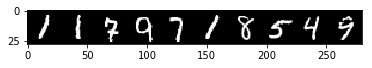

model predictions are: 
[ 1.  1.  7.  9.  7.  1.  8.  5.  4.  9.]
<NDArray 10 @gpu(0)>


In [15]:
import matplotlib.pyplot as plt

def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break